In [3]:
!gsutil -m rsync -r gs://elvos/multichannel_mip_data/ /home/amy/data/amy1

Building synchronization state...
Starting synchronization


In [4]:
!cd /home/amy/data/amy1

In [5]:
!ls /home/amy/data/amy1

04IOS24JP70LHBGB_mip.npy  GB9QW6WTB9XYMMN4_mip.npy  PYZP7WQ4QRH46EFS_mip.npy
0DQO9A6UXUQHR8RA_mip.npy  GBA7XJ5E7ITWZW7K_mip.npy  Q0YMNAR31STBFPG6_mip.npy
0E1AN2T001WORM02_mip.npy  GBXENHYLRVZ5DTHI_mip.npy  Q2ZSL21Z90QTPXY5_mip.npy
0EZJW4R4EMC16I10_mip.npy  GCBJDIT55TRGHZIR_mip.npy  Q7TZ7D9MDFNNTUIE_mip.npy
0KSBX96F8BU1FCFQ_mip.npy  GCSZPU5LPJII8FGU_mip.npy  Q8BNE59JIKQLLYJ1_mip.npy
0LT6HMDHUK63WSC7_mip.npy  GDYRQZ2185AOXLHC_mip.npy  Q8LO6RYLTPQQKJO8_mip.npy
0MG5EK1O64CPS887_mip.npy  GET5PY3CH6RJV3UW_mip.npy  Q9K5IEJR20DGZMSZ_mip.npy
0MTDDGCF20DKOR59_mip.npy  GFFSQZ18XGOVEET0_mip.npy  QA48KZ7WBFX9ZOIA_mip.npy
0OJARUOGIFH5TZKU_mip.npy  GG1EJGK0NHRCBIBA_mip.npy  QBOBDYYD4R7WP37S_mip.npy
0QPSB9IO98216B98_mip.npy  GHD3U9CYRYQ4A0A0_mip.npy  QEMIBYDHSXNH2E6X_mip.npy
0R1R98REO7SARJ06_mip.npy  GHNKISIFB2PFOZ8O_mip.npy  QGEQ4IFSRIA3RBVB_mip.npy
0RB9KGMO90G1YQZD_mip.npy  GHVG2CNNRZ65UBEU_mip.npy  QGH1NCRAPQ9QI8DG_mip.npy
0YSFCN6QTA52Q013_mip.npy  GIPUIOSNW2C34HIS_mip.npy  QI8CI3NDYYJKGP9M_mip.npy

In [1]:
import os
import csv
import random
import numpy as np
from scipy.ndimage.interpolation import zoom
from keras.preprocessing.image import ImageDataGenerator

from google.cloud import storage

BLACKLIST = ['LAUIHISOEZIM5ILF',
             '2018050121043822',
             '2018050120260258']

def normalize(image, lower_bound=None, upper_bound=None):
    # TODO: This is an issue, we can't zero center per image
    if lower_bound is None:
        lower_bound = image.min()
    if upper_bound is None:
        upper_bound = image.max()

    image[image > upper_bound] = upper_bound
    image[image < lower_bound] = lower_bound

    return (image - image.mean()) / image.std()

class MipGenerator(object):

    def __init__(self, dims=(120, 120, 1), batch_size=16,
                 shuffle=True,
                 validation=False,
                 split=0.2, extend_dims=True,
                 augment_data=True):
        self.dims = dims
        self.batch_size = batch_size
        self.extend_dims = extend_dims
        self.augment_data = augment_data
        self.validation = validation

        self.datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )

        # Delete all content in tmp/npy/
        filelist = [f for f in os.listdir('/home/amy/data/amy1/tmp/npy')]
        for f in filelist:
            os.remove(os.path.join('/home/amy/data/amy1/tmp/npy', f))

        # Get npy files from Google Cloud Storage
        gcs_client = storage.Client.from_service_account_json(
            '/home/amy/data/amy1/client_secret.json'
        )
        bucket = gcs_client.get_bucket('elvos')
        blobs = bucket.list_blobs(prefix='multichannel_mip_data/from_numpy/')

        files = []
        for blob in blobs:
            file = blob.name

            # Check blacklist
            blacklisted = False
            for each in BLACKLIST:
                if each in file:
                    blacklisted = True

            if not blacklisted:
                # Add all data augmentation methods
                files.append({
                    "name": file,
                })

                if self.augment_data and not self.validation:
                    self.__add_augmented(files, file)

        # Split based on validation
        if validation:
            files = files[:int(len(files) * split)]
        else:
            files = files[int(len(files) * split):]

        # Get label data from Google Cloud Storage
        blob = storage.Blob('labels.csv', bucket)
        blob.download_to_filename('/home/amy/data/amy1/tmp/labels.csv')
        label_data = {}
        with open('/home/amy/data/amy1/tmp/labels.csv', 'r') as pos_file:
            reader = csv.reader(pos_file, delimiter=',')
            for row in reader:
                if row[0] != 'patient_id':
                    label_data[row[0]] = int(row[1])

        labels = np.zeros(len(files))
        for i, file in enumerate(files):
            filename = file['name']
            filename = filename.split('/')[-1]
            filename = filename.split('.')[0]
            filename = filename.split('_')[0]
            labels[i] = label_data[filename]

        # Take into account shuffling
        if shuffle:
            tmp = list(zip(files, labels))
            random.shuffle(tmp)
            files, labels = zip(*tmp)
            labels = np.array(labels)

        self.files = files
        self.labels = labels
        self.bucket = bucket

    def __add_augmented(self, files, file):
        for i in range(1):
            files.append({
                "name": file,
            })

    def generate(self):
        steps = self.get_steps_per_epoch()
        while True:
            for i in range(steps):
                #print(i)
                x, y = self.__data_generation(i)
                yield x, y

    def get_steps_per_epoch(self):
        return len(self.files) // self.batch_size

    def __data_generation(self, i):
        bsz = self.batch_size
        files = self.files[i * bsz:(i + 1) * bsz]
        labels = self.labels[i * bsz:(i + 1) * bsz]
        images = []

        # Download files to tmp/npy/
        for i, file in enumerate(files):
            blob = self.bucket.get_blob(file['name'])
            file_id = file['name'].split('/')[-1]
            file_id = file_id.split('.')[0]
            blob.download_to_filename(
                '/home/amy/data/amy1/tmp/npy/{}.npy'.format(file_id)
            )
            img = np.load('/home/amy/data/amy1/tmp/npy/{}.npy'.format(file_id))
            os.remove('/home/amy/data/amy1/tmp/npy/{}.npy'.format(file_id))
            img = self.__transform_images(img)
            # print(np.shape(img))
            images.append(img)
        images = np.array(images)
        return images, labels

    def __transform_images(self, image):
        image = np.moveaxis(image, 0, -1)

        # Set bounds
        image[image < -40] = -40
        image[image > 400] = 400

        # Normalize image and expand dims
        image = normalize(image)
        if self.extend_dims:
            if len(self.dims) == 2:
                image = np.expand_dims(image, axis=-1)
            else:
                image = np.repeat(image[:, :, np.newaxis],
                                  self.dims[2], axis=2)

        # Data augmentation methods
        if self.augment_data and not self.validation:
            image = self.datagen.random_transform(image)

        # Interpolate axis to reduce to specified dimensions
        dims = np.shape(image)
        #print(image.shape)
        image = zoom(image, (self.dims[0] / dims[0],
                             self.dims[1] / dims[1],
                             1))
        return image

Using TensorFlow backend.


In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D 
from keras.models import Model
from keras.optimizers import Adam

# Generators
training_generator = MipGenerator(dims=(200,200,3),
                                  extend_dims=False,
                                  batch_size=10,
                                  augment_data=True)
validation_generator = MipGenerator(dims=(200,200,3),
                                  extend_dims=False,
                                  batch_size=10,
                                  augment_data=True,
                                  validation=True)

# expected input shape: (160, 160, 3)
#base_model = applications.nasnet.NASNetMobile(input_shape=(220, 220, 3), include_top=False, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

base_model = applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(200,200,3), pooling=None, classes=1000)
for layer in base_model.layers:
    layer.trainable = False

# build a classifier model to put on top of the convolutional model
# This consists of a global average pooling layer and a fully connected layer with 256 nodes # Then apply dropout and sigmoid activation
model_top = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None))
model_top.add(Dense(1024, activation='relu'))
model_top.add(Dropout(0.7))
model_top.add(Dense(1, activation='sigmoid'))
model = Model(inputs=base_model.input, outputs=model_top(base_model.output))
# Compile model using Adam optimizer with common values and binary cross entropy loss # Use low learning rate (lr) for transfer learning
model.compile(optimizer=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
validation_data=validation_generator.generate()
print(validation_data)

In [3]:
# Train model on dataset
model.fit_generator(generator=training_generator.generate(),
                    validation_data=validation_generator.generate(),
                    steps_per_epoch=training_generator.get_steps_per_epoch(),
                    validation_steps=validation_generator.get_steps_per_epoch(),
                    epochs = 15)

Epoch 1/15


/home/amy/elvo-analysis/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


140/140 [==============================] - 320s 2s/step - loss: 0.7938 - acc: 0.5150 - val_loss: 0.6524 - val_acc: 0.6647
Epoch 2/15
140/140 [==============================] - 303s 2s/step - loss: 0.7515 - acc: 0.5379 - val_loss: 0.6583 - val_acc: 0.6353
Epoch 3/15
140/140 [==============================] - 293s 2s/step - loss: 0.7098 - acc: 0.5843 - val_loss: 0.6688 - val_acc: 0.6176
Epoch 4/15
140/140 [==============================] - 298s 2s/step - loss: 0.6819 - acc: 0.5986 - val_loss: 0.6672 - val_acc: 0.6235
Epoch 5/15
140/140 [==============================] - 297s 2s/step - loss: 0.6669 - acc: 0.6114 - val_loss: 0.6629 - val_acc: 0.6412
Epoch 6/15
140/140 [==============================] - 311s 2s/step - loss: 0.6750 - acc: 0.6221 - val_loss: 0.6648 - val_acc: 0.6471
Epoch 7/15
140/140 [==============================] - 323s 2s/step - loss: 0.6584 - acc: 0.6193 - val_loss: 0.6569 - val_acc: 0.6529
Epoch 8/15
140/140 [==============================] - 328s 2s/step - loss: 0.648

In [10]:
LENGTH, WIDTH, HEIGHT = (120, 120, 64)

VALID_TRAINING_INDICES = []
VALID_VALIDATION_INDICES = []

import pandas as pd

def load_validation_data() -> np.array:
    """Returns 4D matri x of validation data
    Data is in the form (n_samples, 1, w, h). 
    Samples are sorted by patient ID"""
    
    arrays = []
    validation_filenames = sorted(os.listdir(
        '/home/amy/data/amy1/validation/'))
    for i, filename in enumerate(validation_filenames):
        arr = np.load('/home/amy/data/amy1/validation/' + filename)
        if arr.shape == (LENGTH, WIDTH, HEIGHT):
            arrays.append(arr)
            VALID_VALIDATION_INDICES.append(i)
        else:
            print(filename + " has incorrect shape")#logging.info(
             #   f'training file {filename} has incorrect shape {arr.shape}')
    return np.stack(arrays)

def load_labels() -> np.array:
    validation_df = pd.read_csv('/home/amy/data/amy1/validation_labels.csv')
    validation_labels = validation_df.sort_values('patient_id')['label'].values
    return validation_labels

In [11]:
def squash_height(X: np.array):
    return X.max(axis=3) 

In [23]:
X_valid = load_validation_data()
y_valid = load_labels()
y_valid = y_valid[VALID_VALIDATION_INDICES]

X_valid_squashed = squash_height(X_valid)
X_valid = np.stack([X_valid_squashed, X_valid_squashed, X_valid_squashed], axis=3)
X_valid = zoom(X_valid, (1, 200/120, 200/120, 1))

LAUIHISOEZIM5ILF.npy has incorrect shape


In [13]:
from sklearn.metrics import roc_curve

y_pred_keras = model.predict(X_valid).ravel()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_valid, y_pred_keras)

In [14]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.5405566481911914


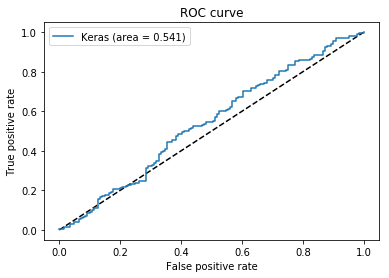

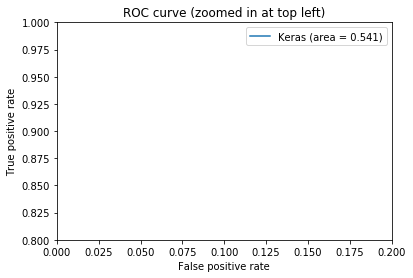

In [19]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [18]:
# import matplotlib library, and plot training cuve
import matplotlib.pyplot as plt 
print(history.history.keys())
plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy') 
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy') 
plt.plot(history.history['loss'], 'red', label='Training loss') 
plt.plot(history.history['val_loss'], 'green', label='Validation loss') 
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
model.save('model-densenet-06-18-18')